In [723]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from collections import defaultdict
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [724]:
df = pd.read_csv('complessivo_rms_finale.csv', index_col='id')
df0 = pd.read_csv('flat_df_no_nulli.csv', index_col=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
id,,,,,,,,,,,,,,,,,,,,,
2,0.005965,0.030530,0.038409,0.052510,0.081335,0.096664,0.092021,0.083451,0.083296,0.086539,...,0.167174,0.126127,0.111858,0.095006,0.099327,0.097803,0.107587,0.152822,0.177150,0.000000
3,0.009710,0.088201,0.120011,0.128533,0.150989,0.169258,0.205793,0.261233,0.279276,0.259404,...,0.126499,0.103162,0.147984,0.207548,0.256682,0.254089,0.194205,0.146202,0.119663,0.121850
5,0.004292,0.036312,0.051975,0.046670,0.203390,0.283229,0.314644,0.322023,0.293859,0.251127,...,0.318426,0.312173,0.305558,0.281919,0.234308,0.178978,0.163058,0.143980,0.120217,0.107188
10,0.110271,0.142744,0.156790,0.131847,0.125279,0.129176,0.128395,0.171358,0.298087,0.304533,...,0.296138,0.217364,0.184314,0.176318,0.161866,0.158079,0.158619,0.148111,0.146005,0.000000
20,0.245351,0.239747,0.211342,0.181047,0.184478,0.177384,0.142504,0.206317,0.242042,0.226818,...,0.333991,0.285059,0.176683,0.181024,0.188473,0.168699,0.164692,0.181571,0.183699,0.000000


# Preprocessing

In [197]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

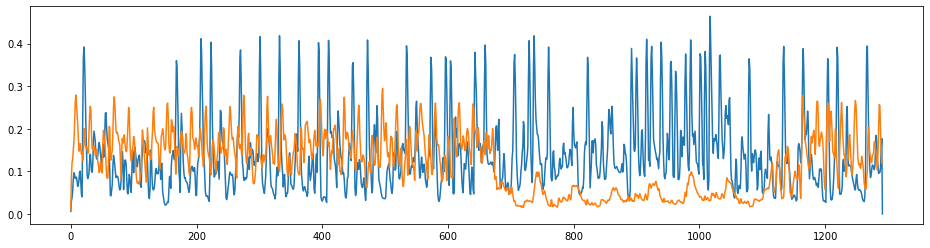

In [198]:
plt.figure(figsize=(16, 4))

ts1 = df[df.index==2].T.values
ts2 = df[df.index==3].T.values

plt.plot(ts1)
plt.plot(ts2)
plt.show()

## Amplitude Scaling

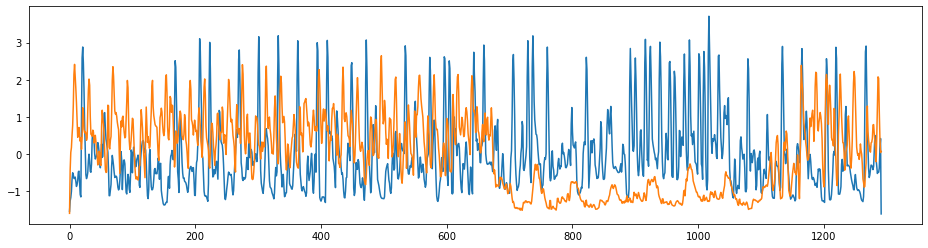

In [199]:
plt.figure(figsize=(16, 4))

scaler = TimeSeriesScalerMeanVariance(mu=0, std=1.)  # Rescale time series
ts1_scaled = scaler.fit_transform(ts1.reshape(1, -1)).flatten()
ts2_scaled = scaler.fit_transform(ts2.reshape(1, -1)).flatten()

plt.plot(ts1_scaled)
plt.plot(ts2_scaled)
plt.show()

## Noise (smoothing)

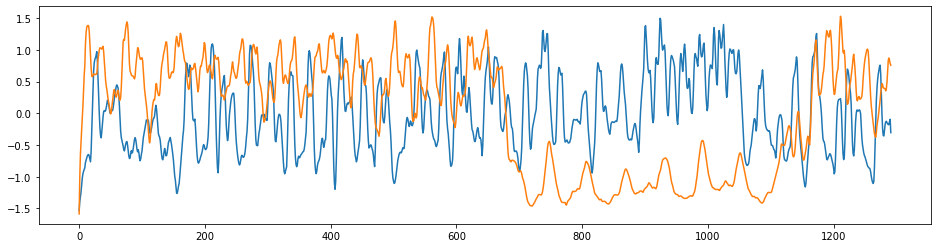

In [200]:
plt.figure(figsize=(16, 4))
w = 10

ts1_ = pd.Series(ts1.reshape(1, -1).squeeze())
ts2_ = pd.Series(ts2.reshape(1, -1).squeeze())

plt.plot(((ts1_ - ts1_.mean())/ts1_.std()).rolling(window=w, min_periods=1).mean())
plt.plot(((ts2_ - ts2_.mean())/ts2_.std()).rolling(window=w, min_periods=1).mean())
plt.show()

In [201]:
#Amplitude scaling
scaler = TimeSeriesScalerMeanVariance(mu=0, std=1.)
df = df.T.apply(lambda x: scaler.fit_transform(x.values.reshape(1, -1)).flatten()).T

In [202]:
#Noise
w = 10
df = df.T.apply(lambda x: ((x - x.mean())/x.std()).rolling(window=w, min_periods=1).mean()).T

# TS Approximation

In [206]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

In [207]:
ts = df[df.index==2].T.values.reshape(1,-1)

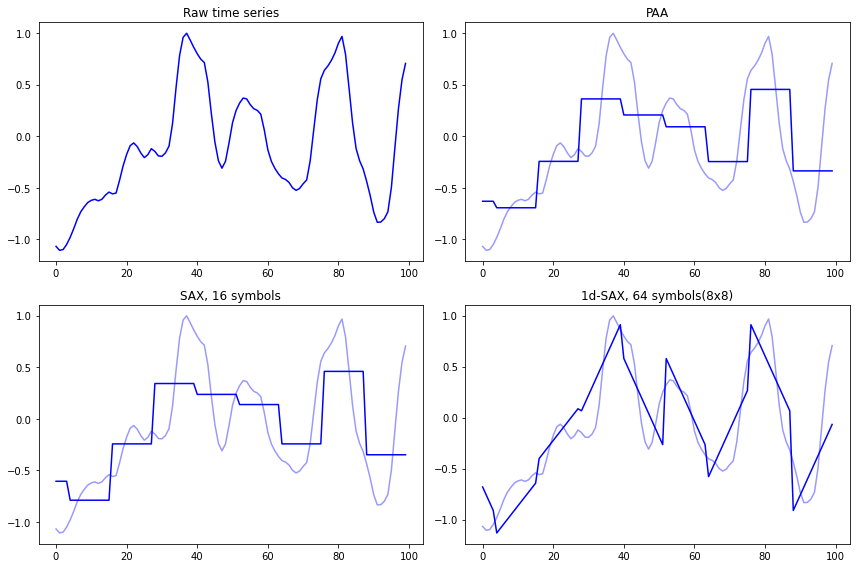

In [208]:
# PAA transform (and inverse transform) of the data
n_paa_segments = 100
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = paa.fit_transform(ts)
paa_dataset_inv = paa.inverse_transform(ts_paa)

# SAX transform
n_sax_symbols = 16
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols, scale=True)
ts_sax = sax.fit_transform(ts)
sax_dataset_inv = sax.inverse_transform(ts_sax)

# 1d-SAX transform
n_sax_symbols_avg = 8
n_sax_symbols_slope = 8
one_d_sax = OneD_SymbolicAggregateApproximation(
    n_segments=n_paa_segments,
    alphabet_size_avg=n_sax_symbols_avg,
    alphabet_size_slope=n_sax_symbols_slope)

ts_sax1d = one_d_sax.fit_transform(ts)
one_d_sax_dataset_inv = one_d_sax.inverse_transform(ts_sax1d)

plt.figure(figsize=(12, 8)) 
plt.subplot(2, 2, 1)  # First, raw time series
plt.plot(ts[0].ravel()[500:600], "b-")
plt.title("Raw time series")

plt.subplot(2, 2, 2)  # Second, PAA
plt.plot(ts[0].ravel()[500:600], "b-", alpha=0.4)
plt.plot(paa_dataset_inv[0].ravel()[500:600], "b-")
plt.title("PAA")

plt.subplot(2, 2, 3)  # Then SAX
plt.plot(ts[0].ravel()[500:600], "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel()[500:600], "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

plt.subplot(2, 2, 4)  # Finally, 1d-SAX
plt.plot(ts[0].ravel()[500:600], "b-", alpha=0.4)
plt.plot(one_d_sax_dataset_inv[0].ravel()[500:600], "b-")
plt.title("1d-SAX, %d symbols"
          "(%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                       n_sax_symbols_avg,
                       n_sax_symbols_slope))

plt.tight_layout()
plt.show()

In [15]:
import warnings
import tqdm as tq
warnings.filterwarnings("ignore")

In [16]:
paa = PiecewiseAggregateApproximation(n_segments=100)

In [17]:
id_list = []
values_list = []
ex = []

for i in tq.tqdm(df.index):
    try:
        values_list.append(paa.fit_transform(df[df.index==i].T.values.reshape(1,-1))[0,:,0])
        id_list.append(i)
    except:
        ex.append(i)

100%|█████████████████████████████████████████████████████████████████████████| 106412/106412 [02:21<00:00, 752.69it/s]


In [18]:
df_approssimato = pd.DataFrame(data=values_list, index=id_list)

In [19]:
df_approssimato

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2,-1.063012,-0.378446,0.425916,0.033017,0.150339,-0.087710,-0.577289,-0.528511,-0.446417,-0.179468,...,0.384126,-0.339522,-0.379817,-0.504463,0.019878,-0.039119,-0.796648,0.869420,-0.114327,-0.700066
3,0.014221,0.995628,0.804789,0.636206,0.192957,0.521068,1.083118,0.746884,0.614796,-0.115630,...,-1.382764,-1.251889,-0.917870,-0.448158,-0.442310,-0.268748,-0.523371,0.691069,0.545334,1.136028
5,-0.409365,0.233493,-0.154301,-0.393842,0.980051,-0.357605,-0.056170,-0.456842,0.977428,0.550632,...,0.263550,-0.074440,-0.432167,-0.306305,0.821702,0.729985,0.202820,-0.863294,0.085117,-0.100107
10,-0.806781,-0.329477,-0.418514,0.039598,-0.355800,-0.787906,-0.397974,-0.421388,-0.085806,-0.533490,...,-0.340388,-0.194084,-0.105177,0.168291,0.016004,0.077183,-0.419088,0.238079,-0.241467,0.534076
20,0.385180,0.805499,-0.266433,-0.158946,0.295217,-0.266670,0.329794,-0.496221,0.907315,0.589161,...,-0.172556,-0.910591,-0.087648,0.433970,1.334203,1.035461,0.620535,0.688058,0.368913,0.363428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148531,0.335927,1.066105,0.390648,-0.796923,0.179508,-0.235022,-0.888049,-1.065139,-0.932360,-1.727303,...,0.178437,0.519667,0.937368,0.699641,-0.215144,-0.306399,0.539079,0.194502,0.844774,0.656468
148532,-0.266527,0.786347,0.912746,0.202720,0.158320,1.979581,1.033920,0.385348,-0.749971,-0.532672,...,-0.523338,-1.298892,-0.312120,0.613477,-0.018867,0.403054,-0.043203,-0.882864,-0.154994,-0.155415
148533,-0.262287,0.186275,0.282665,0.851774,0.167327,1.066599,0.725673,1.404498,0.193719,0.550371,...,0.751087,-0.432827,0.513610,-0.036069,-0.046865,-0.006461,0.567903,-0.297615,-0.844063,-0.363696
148534,-1.122001,-0.490855,-0.010177,1.230833,0.365309,0.548412,-0.023110,-0.555006,-0.760622,-0.356738,...,0.118543,0.074849,-0.796046,-0.452740,-0.434151,1.075671,0.730233,1.113732,0.859832,0.035264


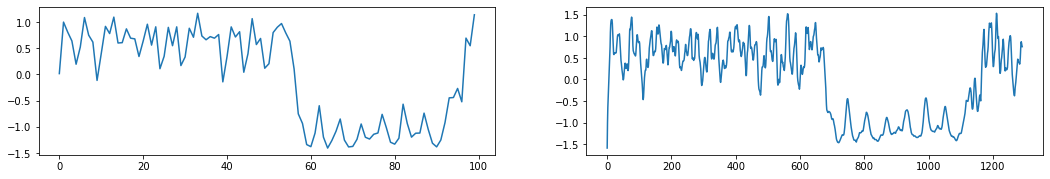

In [20]:
plt.figure(figsize=(18, 6)) 
plt.subplot(2,2,1)
plt.plot(df_approssimato.T[3])
plt.subplot(2,2,2)
plt.plot(df.T[3].values)
plt.show()

In [112]:
#df_approssimato.to_csv("rms_approssimato.csv")

In [347]:
df0[df0["TRACK_genre_top"] == "Rock"].groupby("ARTIST_name").size().sort_values(ascending=False)

ARTIST_name
Disco Missile            144
Obits                    126
+HIRS+                   100
King Ghidorah!            86
Glove Compartment         75
                        ... 
Seven Lines                1
Krallice                   1
Delusions of Grandeur      1
Male Nudity                1
Jaw Horse                  1
Length: 2054, dtype: int64

In [348]:
indici_disco_missile  = df0[df0["ARTIST_name"] == "Disco Missile"].index
indici_obits  = df0[df0["ARTIST_name"] == "Obits"].index

In [356]:
df_disco_missile = df[df.index.isin(indici_disco_missile)]
df_disco_missile = df_disco_missile.dropna()
df_obits = df[df.index.isin(indici_obits)]
df_obits = df_obits.dropna()
df_artist = df_disco_missile.append(df_obits)
df_artist

,0,1,2,3,4,5,6,7,8,9,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
id,,,,,,,,,,,,,,,,,,,,,
60996,-0.096488,-0.040133,-0.121947,-0.336007,-0.492883,-0.583415,-0.631452,-0.650968,-0.696027,-0.774028,...,0.336264,0.374782,0.354199,0.295715,0.223191,0.191253,0.181583,0.187041,0.222643,-0.213858
60997,1.534565,1.360998,1.134653,0.913433,0.763834,0.681515,0.583201,0.473789,0.479446,0.527165,...,-0.071981,-0.133982,-0.152826,-0.177610,-0.171977,-0.108100,-0.009337,0.232402,0.317280,-0.166729
60998,-0.637195,-0.740081,-0.743435,-0.731934,-0.527810,-0.253577,-0.212916,-0.127119,-0.006466,0.114644,...,1.443901,1.275648,1.131771,0.988040,0.796653,0.593152,0.516945,0.524621,0.462096,-0.462733
60999,-0.949935,-0.915079,-0.872772,-0.897946,-0.912695,-0.824920,-0.747253,-0.498284,-0.201828,-0.014629,...,0.435137,0.550071,0.607256,0.386730,0.004093,-0.244719,-0.330389,-0.424448,-0.487036,-0.524986
61000,-0.187152,-0.188871,-0.355424,-0.511384,-0.628414,-0.716045,-0.700114,-0.646144,-0.583709,-0.541957,...,-0.010530,-0.184035,-0.094330,-0.073034,-0.132015,-0.037809,0.039834,0.075176,0.220839,0.444863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91325,-1.745979,-1.428321,-1.199089,-1.158078,-1.208091,-0.962648,-0.685944,-0.518286,-0.405841,-0.328583,...,-0.141617,-0.215103,-0.280639,-0.308954,-0.342671,-0.383385,-0.448847,-0.519726,-0.547313,-0.510509
91326,-1.456553,-1.029590,-0.617192,-0.350179,-0.183513,-0.113082,-0.072759,0.072107,0.271063,0.353082,...,0.488998,0.254015,0.017096,-0.226844,-0.424313,-0.518078,-0.523684,-0.619926,-0.792066,-1.321065
91327,-2.035848,-1.720011,-1.284948,-0.929668,-0.769999,-0.783348,-0.830736,-0.871195,-0.881967,-0.845341,...,-0.838836,-0.752650,-0.505190,-0.341021,-0.354654,-0.443304,-0.508317,-0.492502,-0.445100,-0.705745


In [725]:
indici_rock  = df0[df0["TRACK_genre_top"] == "Rock"].index
indici_classical  = df0[df0["TRACK_genre_top"] == "Classical"].index
indici_other  = df0[df0["TRACK_genre_top"] != "Rock"].index

In [726]:
df_rock_appr = df_approssimato[df_approssimato.index.isin(indici_rock)]
df_rock_appr = df_rock_appr.dropna()
df_other_appr = df_approssimato[df_approssimato.index.isin(indici_other)]
df_other_appr = df_other_appr.dropna()
df_unito_appr = df_rock_appr[:2000].append(df_other_appr[:2000])

In [761]:
df_rock = df[df.index.isin(indici_rock)]
df_rock = df_rock.dropna()
df_classical = df[df.index.isin(indici_classical)]
df_classical = df_classical.dropna()
df_other = df[df.index.isin(indici_other)]
df_other = df_other.dropna()
df_unito = df_rock[3000:4000].append(df_classical)
#df_unito = df_rock.append(df_classical)

In [762]:
print("df_rock: ", df_rock.shape)
print("df_classical: ", df_classical.shape)
print("df_other: ", df_other.shape)
df_unito

df_rock:  (14145, 1292)
df_classical:  (1212, 1292)
df_other:  (91243, 1292)


,0,1,2,3,4,5,6,7,8,9,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
id,,,,,,,,,,,,,,,,,,,,,
32001,0.088924,0.152736,0.187025,0.153150,0.123254,0.118792,0.133108,0.283001,0.356038,0.289294,...,0.194601,0.199442,0.233375,0.250096,0.255140,0.249346,0.224835,0.190025,0.184305,0.000000
32002,0.071512,0.099744,0.120774,0.133373,0.151941,0.164660,0.167389,0.172615,0.192627,0.184515,...,0.256672,0.240069,0.224933,0.200385,0.198298,0.237429,0.225997,0.185742,0.213062,0.187137
32014,0.017102,0.094366,0.123866,0.117731,0.119637,0.114359,0.106221,0.103315,0.108202,0.112633,...,0.106946,0.102465,0.097496,0.094466,0.103986,0.170288,0.190161,0.140380,0.108953,0.000000
32015,0.099029,0.131912,0.162096,0.149689,0.125352,0.115118,0.109882,0.097378,0.095479,0.187985,...,0.100460,0.094999,0.096369,0.083224,0.114916,0.218698,0.219583,0.165698,0.177638,0.166899
32016,0.015313,0.100435,0.162526,0.175657,0.164785,0.156159,0.158828,0.165025,0.159082,0.151351,...,0.123620,0.131864,0.138266,0.193881,0.183251,0.119422,0.107992,0.090080,0.086796,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146001,0.019806,0.076769,0.103605,0.086185,0.069797,0.090654,0.105106,0.101652,0.088589,0.077980,...,0.024657,0.021282,0.019169,0.017170,0.015567,0.015536,0.025208,0.048928,0.152527,0.000000
146002,0.005888,0.057091,0.085711,0.085149,0.085550,0.079793,0.067263,0.059629,0.046451,0.062677,...,0.048254,0.044807,0.041042,0.036420,0.030961,0.028832,0.031326,0.035924,0.040230,0.000000
148488,0.016785,0.132919,0.185482,0.206148,0.252011,0.265144,0.237198,0.212507,0.212602,0.214148,...,0.187641,0.218515,0.222642,0.238042,0.307139,0.332483,0.268491,0.213965,0.223671,0.194248


# Clustering

## Shape-based Clustering

In [729]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

In [763]:
#X = df_unito_appr.values
#X = df_rock.values
#X = df_artist
X = df_unito

In [771]:
n_clusters=3
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=50, random_state=0, n_jobs=-1, verbose=True)
km.fit(X)

12.781 --> 7.342 --> 6.432 --> 6.249 --> 6.187 --> 6.158 --> 6.139 --> 6.124 --> 6.104 --> 6.092 --> 6.089 --> 6.086 --> 6.084 --> 6.082 --> 6.081 --> 6.080 --> 6.080 --> 6.080 --> 6.080 --> 6.080 --> 6.080 --> 


TimeSeriesKMeans(n_jobs=-1, random_state=0, verbose=True)

In [772]:
km.cluster_centers_.shape

(3, 1292, 1)

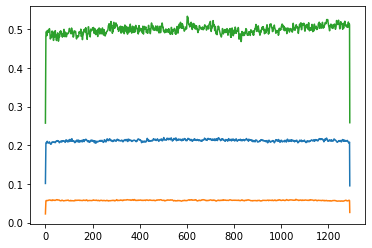

In [773]:
plt.plot(np.squeeze(km.cluster_centers_).T)
plt.show()

In [774]:
silhouette_avg = silhouette_score(X, km.labels_)
silhouette_avg

0.5059816956005836

In [775]:
km.inertia_

6.079906508471864

In [776]:
unique, counts = np.unique(km.labels_, return_counts=True)
unique, counts

(array([0, 1, 2], dtype=int64), array([ 718, 1395,   99], dtype=int64))

In [777]:
for i in range(n_clusters):
    print("#Rock in cluster", i ,"=",(np.where(km.labels_ == i)[0] < 1000).sum(), 
          "#Classical in cluster", i ,"=",(np.where(km.labels_ == i)[0] > 1000).sum())

#Rock in cluster 0 = 653 #Classical in cluster 0 = 65
#Rock in cluster 1 = 248 #Classical in cluster 1 = 1146
#Rock in cluster 2 = 99 #Classical in cluster 2 = 0


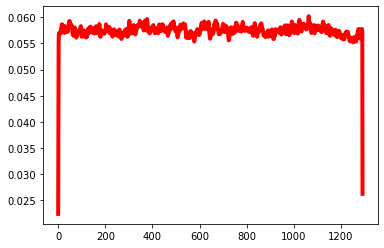

In [811]:
#plt.plot(X[np.where(km.labels_ == 1)[0]].T.squeeze(), c='black', alpha=0.09, linewidth=0.5)
plt.plot(np.squeeze(km.cluster_centers_[1]).T, linewidth=4, c="r")
plt.show()

In [784]:
len(np.where(km.labels_ == 1)[0])

1395

In [812]:
#X = df_rock
#X = df_unito_appr
X = df_unito
#X = df_artist
paa = PiecewiseAggregateApproximation(n_segments=50)
X_paa = paa.fit_transform(X)

In [813]:
n_clusters=3
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0, n_jobs=-1, max_iter_barycenter=10, verbose=True)
km_dtw.fit(X_paa)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2212 out of 2212 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=

0.249 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6636 out of 6636 | elapsed:    0.6s finished


0.083 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 6636 out of 6636 | elapsed:    0.5s finished


0.082 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6636 out of 6636 | elapsed:    0.6s finished


0.081 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6636 out of 6636 | elapsed:    0.6s finished


0.081 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6636 out of 6636 | elapsed:    0.5s finished


TimeSeriesKMeans(max_iter=5, max_iter_barycenter=10, metric='dtw', n_jobs=-1,
                 random_state=0, verbose=True)

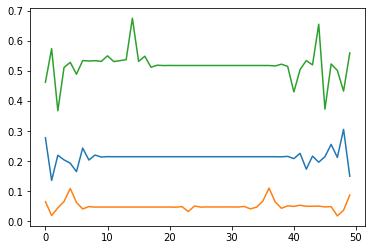

In [814]:
plt.plot(np.squeeze(km_dtw.cluster_centers_).T)
plt.show()

In [815]:
km_dtw.labels_

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [816]:
km_dtw.inertia_

0.0805477848164168

In [817]:
for i in range(n_clusters):
    print("#Rock in cluster", i ,"=",(np.where(km_dtw.labels_ == i)[0] < 1000).sum(), 
          "#Classical in cluster", i ,"=",(np.where(km_dtw.labels_ == i)[0] > 1000).sum())

#Rock in cluster 0 = 683 #Classical in cluster 0 = 75
#Rock in cluster 1 = 224 #Classical in cluster 1 = 1136
#Rock in cluster 2 = 93 #Classical in cluster 2 = 0


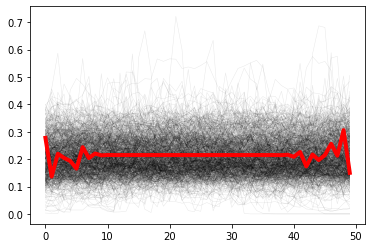

In [818]:
plt.plot(X_paa[np.where(km_dtw.labels_ == 0)[0]].T.squeeze(), c='black', alpha=0.09, linewidth=0.5)
plt.plot(np.squeeze(km_dtw.cluster_centers_[0]).T, linewidth=4, c="r")
plt.show()

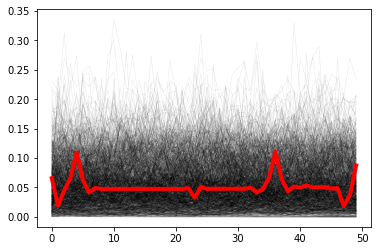

In [819]:
plt.plot(X_paa[np.where(km_dtw.labels_ == 1)[0]].T.squeeze(), c='black', alpha=0.09, linewidth=0.5)
plt.plot(np.squeeze(km_dtw.cluster_centers_[1]).T, linewidth=4, c="r")
plt.show()

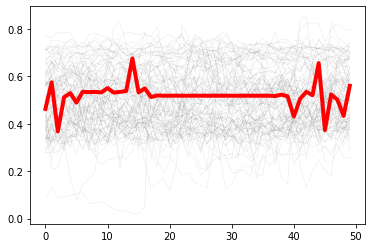

In [820]:
plt.plot(X_paa[np.where(km_dtw.labels_ == 2)[0]].T.squeeze(), c='black', alpha=0.09, linewidth=0.5)
plt.plot(np.squeeze(km_dtw.cluster_centers_[2]).T, linewidth=4, c="r")
plt.show()

In [822]:
n_clusters=3
km_sdtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", max_iter=5, random_state=0, n_jobs=-1, verbose=True)
km_sdtw.fit(X_paa)

6929.339 --> 6975.298 --> 6978.145 --> 6980.127 --> 6981.743 --> 


TimeSeriesKMeans(max_iter=5, metric='softdtw', n_jobs=-1, random_state=0,
                 verbose=True)

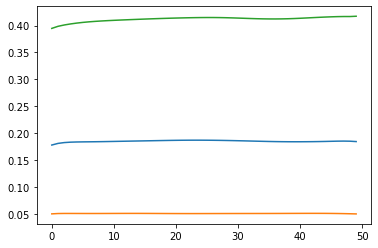

In [823]:
plt.plot(np.squeeze(km_sdtw.cluster_centers_).T)
plt.show()

In [824]:
km_sdtw.labels_

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [825]:
km_sdtw.inertia_

6981.7425266135515

In [826]:
for i in range(n_clusters):
    print("#Rock in cluster", i ,"=",(np.where(km_dtw.labels_ == i)[0] < 1000).sum(), 
          "#Classical in cluster", i ,"=",(np.where(km_dtw.labels_ == i)[0] > 1000).sum())

#Rock in cluster 0 = 683 #Classical in cluster 0 = 75
#Rock in cluster 1 = 224 #Classical in cluster 1 = 1136
#Rock in cluster 2 = 93 #Classical in cluster 2 = 0


In [53]:
import pickle
pickle.dump(km_dtw, open("TimeSeriesKMeans.pickle", 'wb'))

#TimeSeriesKMeans = pickle.load(open("TimeSeriesKMeans.pickle", 'rb'))

In [649]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

## Features-based Clustering

In [827]:
from sklearn.cluster import KMeans

In [828]:
F = [list(calculate_features(x).values())[:-2] for x in X]

TypeError: cannot perform reduce with flexible type

In [646]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(F)

KMeans(n_clusters=5)

In [647]:
kmeans.inertia_

1907.7272033847942

In [648]:
for i in range(5):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

KeyError: "None of [Int64Index([   20,    28,    57,    61,    62,    78,    91,    97,   101,\n              102,\n            ...\n            14081, 14092, 14099, 14101, 14105, 14121, 14128, 14130, 14139,\n            14140],\n           dtype='int64', length=3364)] are in the [columns]"

In [829]:
X = df_unito
sz = X.shape[1]

Euclidean k-means
67.928 --> 39.675 --> 38.863 --> 38.698 --> 38.644 --> 38.612 --> 38.580 --> 38.559 --> 38.536 --> 38.516 --> 38.494 --> 38.455 --> 38.410 --> 38.371 --> 38.343 --> 38.315 --> 38.300 --> 38.297 --> 38.293 --> 38.289 --> 38.283 --> 38.278 --> 38.275 --> 38.274 --> 38.273 --> 38.273 --> 
DBA k-means


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished
[Parall

17.600 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


14.320 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


14.097 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


13.960 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


13.886 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


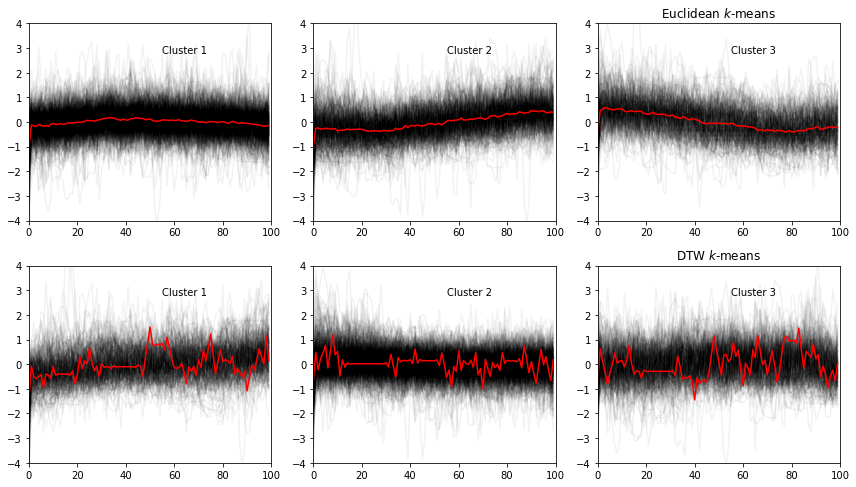

In [145]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=0, n_jobs=-1, max_iter=50)
km.fit(X)

plt.figure(figsize=(12, 10)) 
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X[km.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.05)
    plt.plot(np.squeeze(km.cluster_centers_[yi]).T, "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=0,
                          n_jobs=-1,
                          max_iter=5)
dba_km.fit(X)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in X[dba_km.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.05)
    plt.plot(np.squeeze(dba_km.cluster_centers_[yi]).T, "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("DTW $k$-means")

plt.tight_layout()
plt.show()